<a href="https://colab.research.google.com/github/swethasrihari/privacy-project-team1/blob/main/diffpriv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import pandas as pd
path ='/content/drive/MyDrive/Colab Notebooks/Privacy_Project/cleanedAdultIncome.csv'

In [47]:
dataset = pd.read_csv(path)


In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, dataset['income'], test_size=0.2)

In [49]:
pip install diffprivlib


In [50]:
print(dataset.max())
#category_col =['workclass', 'race', 'education','educational-num','marital-status', 'occupation',
 #              'relationship', 'gender', 'age', 'income','native-country']

Unnamed: 0                    48841
age                              90
workclass               Without-pay
fnlwgt                      1490400
education              Some-college
educational-num                  16
marital-status              Widowed
occupation         Transport-moving
relationship                   Wife
race                          White
gender                         Male
capital-gain                  99999
capital-loss                   4356
hours-per-week                   99
native-country           Yugoslavia
income                         >50K
dtype: object


In [51]:
# replace the Divorced, Never-married, Separated to not married and the rest to married
dataset.replace(['Divorced', 'Married-AF-spouse',
              'Married-civ-spouse', 'Married-spouse-absent',
              'Never-married','Separated','Widowed'],
             ['not married','married','married','married',
              'not married','not married','not married'], inplace = True)


In [52]:
import numpy as np
for col in category_col:
    b, c = np.unique(dataset[col], return_inverse=True)
    dataset[col] = c

dataset

,Unnamed: 0,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,0,8,2,226802,1,6,1,6,3,2,1,0,0,40,38,0
1,1,21,2,89814,11,8,0,4,0,4,1,0,0,50,38,0
2,2,11,1,336951,7,11,0,10,0,4,1,0,0,40,38,1
3,3,27,2,160323,15,9,0,6,0,2,1,7688,0,40,38,1
4,5,17,2,198693,0,5,1,7,1,4,1,0,0,30,38,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,48837,10,2,257302,7,11,0,12,5,4,0,0,0,38,38,0
45218,48838,23,2,154374,11,8,0,6,0,4,1,0,0,40,38,1
45219,48839,41,2,151910,11,8,1,0,4,4,0,0,0,40,38,0
45220,48840,5,2,201490,11,8,1,0,3,4,1,0,0,20,38,0


In [53]:
from scipy import stats

col_names = dataset.columns

param=[]
correlation=[]
abs_corr=[]

for c in col_names:
    #Check if binary or continuous
    if c != "income":
        if len(dataset[c].unique()) <= 2:
            corr = stats.spearmanr(dataset['income'],dataset[c])[0]
        else:
            corr = stats.pointbiserialr(dataset['income'],dataset[c])[0]
        param.append(c)
        correlation.append(corr)
        abs_corr.append(abs(corr))

#Create dataframe for visualization
param_df=pd.DataFrame({'correlation':correlation,'parameter':param, 'abs_corr':abs_corr})

#Sort by absolute correlation
param_df=param_df.sort_values(by=['abs_corr'], ascending=False)

#Set parameter name as index
param_df=param_df.set_index('parameter')

param_df

,correlation,abs_corr
parameter,,
marital-status,-0.437678,0.437678
educational-num,0.332800,0.332800
relationship,-0.253402,0.253402
age,0.237040,0.237040
hours-per-week,0.227199,0.227199
capital-gain,0.221034,0.221034
gender,0.215760,0.215760
capital-loss,0.148687,0.148687
education,0.081196,0.081196


In [54]:
predictors = ['workclass','education','educational-num','age',
              'marital-status', 'occupation','relationship','race','gender']
high_income = dataset[dataset['income'] == 1]
low_income = dataset[dataset['income'] == 0]
# stratified sampling
#80% to train set
train = pd.concat([high_income.sample(frac=0.8, random_state=1),
                   low_income.sample(frac=0.8, random_state=1)])
y_train = train["income"]
X_train = train[predictors]

#10% to test set
test = pd.concat([high_income.sample(frac=0.1, random_state=1),
                  low_income.sample(frac=0.1, random_state=1)])
y_test = test["income"]
X_test = test[predictors]

#10% to Cross Validation set
cross = pd.concat([high_income.sample(frac=0.1, random_state=2),
                   low_income.sample(frac=0.1, random_state=2)])
y_cross = cross["income"]
X_cross = cross[predictors]

In [55]:
from diffprivlib.models import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/diffprivlib/models/naive_bayes.py:107: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "


GaussianNB(accountant=BudgetAccountant(spent_budget=[(1.0, 0), (1.0, 0)]),
           bounds=(array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
                   array([ 6., 15., 15., 73.,  1., 13.,  5.,  4.,  1.])))

In [56]:
y_pred = clf.predict(X_test)

In [57]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print("Random Forest Classification Report")
print(report)

Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      3401
           1       0.51      0.71      0.59      1121

    accuracy                           0.76      4522
   macro avg       0.70      0.74      0.71      4522
weighted avg       0.79      0.76      0.77      4522



In [61]:
for c in category_col:
    print (c)
    print (dataset[c].value_counts())
print(X_train.max())
print(X_train.min())

workclass
2    33307
4     3796
1     3100
5     1946
3     1646
0     1406
6       21
Name: workclass, dtype: int64
race
4    38903
2     4228
1     1303
0      435
3      353
Name: race, dtype: int64
education
11    14783
15     9899
9      7570
12     2514
8      1959
1      1619
7      1507
0      1223
5       823
14      785
6       676
2       577
10      544
4       449
3       222
13       72
Name: education, dtype: int64
educational-num
8     14783
9      9899
12     7570
13     2514
10     1959
6      1619
11     1507
5      1223
3       823
14      785
4       676
7       577
15      544
2       449
1       222
0        72
Name: educational-num, dtype: int64
marital-status
1    23583
0    21639
Name: marital-status, dtype: int64
occupation
2     6020
9     6008
3     5984
0     5540
11    5408
7     4808
6     2970
13    2316
5     2046
4     1480
12    1420
10     976
8      232
1       14
Name: occupation, dtype: int64
relationship
0    18666
1    11702
3     6626
4     47

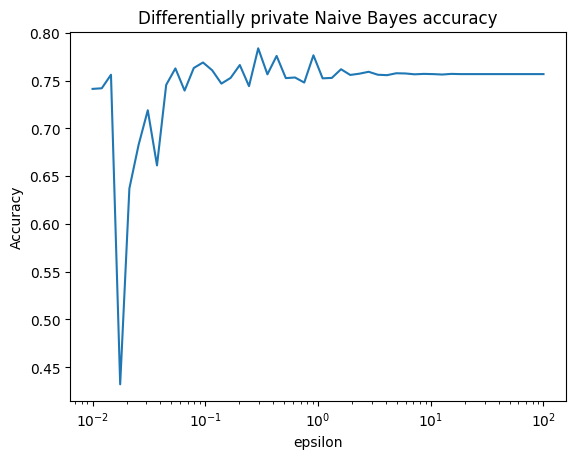

In [66]:
import numpy as np
import matplotlib.pyplot as plt

epsilons = np.logspace(-2, 2, 50)
bounds = ([0,0,0,0,0,0,0,0,0], [6,15,15,73,1,13,5,4,1])
accuracy = list()

for epsilon in epsilons:
    clf = GaussianNB(bounds=bounds, epsilon=epsilon)
    clf.fit(X_train, y_train)

    accuracy.append(clf.score(X_test, y_test))

plt.semilogx(epsilons, accuracy)
plt.title("Differentially private Naive Bayes accuracy")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.show()